### We use residual connections, training context length = 32, batch size = 64

In [1]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from rotary_embedding_torch import RotaryEmbedding

import math
from dataclasses import dataclass
from typing import Union
from pscan_mine import pscan
from mamba import MambaBlock
import json

### Tasks

There are three kinds of related tasks being completed:
1. Induction head: For a specific token A, learn to find the previous occurence of A, find the token B that came after that occurence and return B. We are building a 2 layer transformer model for the induction task. 
2. Associative recall: Same task as the induction head task except that we need the model to learn to recall the next token for **multiple** query tokens A.
3. Associative recall with delay: Same task as associative recall, but instead of the next token, we need to find the next token with gap or _delay_ tau.

I have added a parameter called tau below, which can be used to adjust the delay in the dataset

In [2]:
class InductionAR(Dataset):
    # In induction head we have ngram = 1. 
    """ Naive associative recall dataset """
    def __init__(self, num_examples, tokenizer, tau=1, n_gram=1, n_ctx = 1024, seed = 0, train_split=0.8):
        self.num_examples = num_examples
        self.tokenizer = tokenizer
        self.n_ctx = n_ctx
        self.tau = tau
        self.seed = seed
        self.n_gram = n_gram
        x, y = self.data_gen()
        if train_split:
            self.train_x, self.train_y, self.test_x, self.test_y = self.split(x, y, train_split)
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = self.numpy_to_tensor_dataset(self.test_x, self.test_y)
        else:
            self.train_x, self.train_y, self.test_x, self.test_y = x, y, None, None
            self.train = self.numpy_to_tensor_dataset(self.train_x, self.train_y)
            self.test = None
    def get_str_dataset(self, split="train"):
        if split == "train":
            x_str = [self.tokenizer.decode(xi) for xi in self.train_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.train_y]
        elif split == "test":
            x_str = [self.tokenizer.decode(xi) for xi in self.test_x]
            y_str = [self.tokenizer.decode([yi]) for yi in self.test_y]
        else:
            raise ValueError("split should be either 'train' or 'test'")
        return x_str, y_str
    def numpy_to_tensor_dataset(self, x, y):
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return TensorDataset(x, y)
    def gen_single_example(self):
        # get the vocab size
        def count(str_x, str_n_gram_head):
            counts = sum([
                str_x.startswith(str_n_gram_head, i) for i in range(len(str_x))
            ])
            return counts
        def gen_x():
            gen_x_success = False
            while not gen_x_success:
                x = np.random.choice(vocab, self.n_ctx-self.n_gram*2, replace=True).tolist()
                # remove the case where the n_gram_head is repeated in the sequence
                for _ in range(10):
                    pos = [i for i in range(len(x)-len(n_gram_head)+1) if x[i:i+len(n_gram_head)] == n_gram_head]
                    if len(pos) == 0:
                        gen_x_success = True
                        break
                    else:
                        # remove the n_gram_head from x
                        # get all positions of the n_gram_head in x
                        for p in reversed(pos):
                            # remove len(n_gram_head) elements from x starting from p
                            x = x[:p] + x[p+len(n_gram_head):]
                        # fill the rest of the sequence with random elements
                        x.extend(np.random.choice(vocab, self.n_ctx-self.n_gram*2-len(x), replace=True).tolist())
                x_test = " ".join([str(xi) for xi in x])
                if count(x_test, str_n_gram_head) == 0:
                    gen_x_success = True

            x_test = x + n_gram_head
            # check if there's only one n_gram_head in the sequence
            # to avoid the case where the n_gram_head has
            # repeated structure such as x= [1, 2, 3, 1] , n_gram_head = [1, 1]
            str_x_test = " "+" ".join([str(xi) for xi in x_test])+ " "
            if count(str_x_test, str_n_gram_head) > 1:
                print("Error in gen_x")
                print(f"str_x_test: {str_x_test}", f"str_n_gram_head: {str_n_gram_head}",
                      "count: ", count(str_x_test, str_n_gram_head))
            if count(str_x_test, str_n_gram_head) == 1:
                return x
            else:
                return None
        
        # this is where the value of the delay (tau) is used
        def insert_n_gram_head(x, tau):
            pos = random.randint(tau-1, len(x)-1)
            y = x[pos]
            x_new = x[:pos-tau+1] + n_gram_head + x[pos-tau+1:] + n_gram_head
            str_x_new = " "+" ".join([str(xi) for xi in x_new])+" "

            if count(str_x_new, str_n_gram_head) == 2:
                return x_new, y
            else:
                return None, None
        vocab_size = len(self.tokenizer)
        vocab = list(range(vocab_size))
        # set a deterministic n_gram_head
        n_gram_head = list(range(self.n_gram))

        str_n_gram_head = " "+" ".join([str(xi) for xi in n_gram_head])+" "
        assert self.n_gram*2 < self.n_ctx, "n_gram*2 should be less than n_ctx"
        success = False
        while not success:
            x = gen_x()
            if x is not None:
                for _ in range(10):
                    x_new, y = insert_n_gram_head(x, self.tau)
                    if x_new is not None:
                        success = True
                        break
        return x_new, y

    def data_gen(self):
        x = []
        y = []
        # get previous random status and recover after generating the dataset
        random_status = random.getstate()
        random.seed(self.seed)
        for i in range(self.num_examples):
            if i % 1000 == 0:
                print(f"Generating example {i}")
            xi, yi = self.gen_single_example()
            x.append(xi)
            y.append(yi)
        x = np.array(x)
        y = np.array(y)
        random.setstate(random_status)
        return x, y
    def split(self, x, y, train_ratio = 0.8):
        num_train = int(len(x)*train_ratio)
        train_x = x[:num_train]
        train_y = y[:num_train]
        test_x = x[num_train:]
        test_y = y[num_train:]
        return train_x, train_y, test_x, test_y


The tokenizer is quite standard.

In [3]:
# Random tokenizer
class Random_tokenizer:
    def __init__(self, vocab=None, vocab_size = None) -> None:
        """ The init function of the tokenizer class.
         one of vocab or vocab_size should be provided.
         If vocab is provided, vocab_size will be ignored.
         If vocab is not provided, vocab_size should be provided. we will generate a random vocab of vocab_size."""
        if vocab is not None:
            self.vocab = vocab
            self.vocab_size = len(vocab)
        elif vocab_size is not None:
            self.vocab_size = vocab_size
            self.vocab = [str(i) for i in range(vocab_size)]
        else:
            raise ValueError("one of vocab or vocab_size should be provided.")
        self.vocab_dict = {v: i for i, v in enumerate(self.vocab)}
        self.vocab_dict_inv = {i: v for i, v in enumerate(self.vocab)}
    def encode(self, x):
        """ Encode a string into a list of integers """
        return [self.vocab_dict[i] for i in x]
    def decode(self, x):
        """ Decode a list of integers into a string """
        return ' '.join([self.vocab_dict_inv[i] for i in x])
    def __len__(self):
        return self.vocab_size
    def __getitem__(self, i):
        return self.vocab[i]
    def __iter__(self):
        return iter(self.vocab)
    def __contains__(self, x):
        return x in self.vocab
    def __repr__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __str__(self):
        return f"Random_tokenizer(vocab_size={self.vocab_size})"
    def __call__(self, x):
        return self.encode(x)


Added rotary embeddings to the usual attention block

In [4]:
# self attention block
class Block(nn.Module):
    def __init__(self, embed_dim, max_len=11, is_rope=False):
        super(Block, self).__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.is_rope = is_rope
        if self.is_rope:
            self.rotary_emb = RotaryEmbedding(dim = self.embed_dim)
        self.c_attn = nn.Linear(embed_dim, embed_dim*3)
        self.register_buffer('mask', torch.tril(torch.ones(max_len, max_len)))
    def forward(self, x):
        T = x.size(1)
        q, k, v = self.c_attn(x).chunk(3, dim=-1)
        if self.is_rope:
            q = self.rotary_emb.rotate_queries_or_keys(q)
            k = self.rotary_emb.rotate_queries_or_keys(k)
        y = torch.nn.functional.scaled_dot_product_attention(q, k, v, is_causal=True)
        return y

Made a class BaseNet for the base network, and added a class called MambaNet that constructs a network using a list of blocks instead of a block type, unlike BaseNet. This is so that we can pass blocks of different kinds, like Mamba and attention, to make Mamba-attention hybrids

In [5]:
# Class for Layer norm
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

# Class from original code to make a network from a type of block
class BaseNet(nn.Module):
    def __init__(self, vocab_size, embed_dim,
                 is_pe = False, max_len=11,
                 attn_layers=2, block=None,
                 **kwargs):
        super(BaseNet, self).__init__()
        if block is None:
            raise ValueError("block type should be provided.")
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.is_pe = is_pe
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.pe = nn.Embedding(max_len, embed_dim) if is_pe else None
        self.att = nn.ModuleList([block(embed_dim, max_len, **kwargs) for _ in range(attn_layers)])
        self.ln = nn.ModuleList([LayerNorm(embed_dim, True) for _ in range(attn_layers)])
        self.head = nn.Linear(embed_dim, vocab_size)

        print(f"BaseNet with {attn_layers} layers of {block} blocks")
        print(f"Embedding dimension: {embed_dim}")
        print(f"Positional Encoding: {is_pe}")
        print(f"Vocabulary size: {vocab_size}")
        print(f"Context length: {max_len}")

    def forward(self, x):
        b, t = x.size()
        x = self.embed(x)
        if self.is_pe:
            pos = torch.arange(0, t, dtype=torch.long, device=x.device)
            pe_emb = self.pe(pos) if self.is_pe else 0
            x = x + pe_emb
        for layer, ln in zip(self.att, self.ln):
            x = ln(x+layer(x))
        x = self.head(x)
        return x

# Class to make network using a list of blocks instead of a type of block
class MambaNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, blocks=None,
                 **kwargs):
        super(MambaNet, self).__init__()
        if blocks is None:
            raise ValueError("block list should be provided.")
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.blocks = blocks
        self.ln = nn.ModuleList([LayerNorm(embed_dim, True) for _ in range(len(blocks))])
        self.head = nn.Linear(embed_dim, vocab_size)

        print(f"MambaNet with {len(blocks)} blocks: {blocks}")
        print(f"Embedding dimension: {embed_dim}")
        print(f"Positional Encoding: {is_pe}")
        print(f"Vocabulary size: {vocab_size}")

    def forward(self, x):
        b, t = x.size()
        x = self.embed(x)
        for layer, ln in zip(self.blocks, self.ln):
            x = ln(x+layer(x))
        x = self.head(x)
        return x

## Testing length generalization with tau=1, train context length = 32, batch size = 64, using residual connections

Isolated code to make the tau=1 dataset

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
seed = 0
n_ctx = 32 # training sequence length
num_examples = 100000 # generate 100000 examples
batch_size = 64 # batch size
vocab_size = 16 # vocabulary size
num_epochs = 250    # number of epochs
attn_layers = 2 # number of attention layers
embed_dim = 8 # embedding dimension
is_pe = True  # the default positional embedding we are using is the learned positional embedding
no_pe = False

tokenizer = Random_tokenizer(vocab_size=vocab_size)
# Setting tau = 1
dataset = InductionAR(num_examples, tokenizer, tau=1, n_gram=1, n_ctx=n_ctx, seed=seed, train_split=0.8)
train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

Using cuda device
Generating example 0
Generating example 1000
Generating example 2000
Generating example 3000
Generating example 4000
Generating example 5000
Generating example 6000
Generating example 7000
Generating example 8000
Generating example 9000
Generating example 10000
Generating example 11000
Generating example 12000
Generating example 13000
Generating example 14000
Generating example 15000
Generating example 16000
Generating example 17000
Generating example 18000
Generating example 19000
Generating example 20000
Generating example 21000
Generating example 22000
Generating example 23000
Generating example 24000
Generating example 25000
Generating example 26000
Generating example 27000
Generating example 28000
Generating example 29000
Generating example 30000
Generating example 31000
Generating example 32000
Generating example 33000
Generating example 34000
Generating example 35000
Generating example 36000
Generating example 37000
Generating example 38000
Generating example 3

Code for training models with the tau=1 dataset and saving them. already_done maintains a list of models that have already been trained, to account for executing the training code over multiple sessions.

In [7]:
attn_model = BaseNet(len(tokenizer), embed_dim, is_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=Block, is_rope=False).to(device)
nope_model = BaseNet(len(tokenizer), embed_dim, no_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=Block, is_rope=False).to(device)
rope_model = BaseNet(len(tokenizer), embed_dim, no_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=Block, is_rope=True).to(device)

mamba_blocks = nn.ModuleList([MambaBlock(embed_dim), MambaBlock(embed_dim)])
hybrid_a_blocks = nn.ModuleList([MambaBlock(embed_dim), Block(embed_dim, max_len = 4*n_ctx)])
hybrid_b_blocks = nn.ModuleList([MambaBlock(embed_dim), Block(embed_dim, max_len = 4*n_ctx), MambaBlock(embed_dim)])

mamba = MambaNet(len(tokenizer), embed_dim, mamba_blocks).to(device)
hybrid_a = MambaNet(len(tokenizer), embed_dim, hybrid_a_blocks).to(device)
hybrid_b = MambaNet(len(tokenizer), embed_dim, hybrid_b_blocks).to(device)

already_done = ["pe", "nope", "rope", "mamba", "hybrid_a", "hybrid_b"]
models = {"pe": attn_model, "nope":nope_model, "rope":rope_model, "mamba": mamba, "hybrid_a":hybrid_a, "hybrid_b": hybrid_b} 

for model_name in already_done:
    models[model_name].load_state_dict(torch.load("tau1_models/" + model_name + ".pt"))

# Training code
for model_name in models:
    if (model_name not in already_done):
        print(model_name)
        model = models[model_name]
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model(x)[:,-1]
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"epoch {epoch} loss: {total_loss/len(train_loader)}")

        # Eval model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)[:,-1]
                y_pred = F.softmax(y_pred, dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                correct += (y_pred == y).sum().item()
                total += y.size(0)
                
        print(f"Test accuracy: {correct/total}")
            
        # Save model
        torch.save(model.state_dict(), "tau1_models/" + f"{model_name}.pt")



BaseNet with 2 layers of <class '__main__.Block'> blocks
Embedding dimension: 8
Positional Encoding: True
Vocabulary size: 16
Context length: 128
BaseNet with 2 layers of <class '__main__.Block'> blocks
Embedding dimension: 8
Positional Encoding: False
Vocabulary size: 16
Context length: 128
BaseNet with 2 layers of <class '__main__.Block'> blocks
Embedding dimension: 8
Positional Encoding: False
Vocabulary size: 16
Context length: 128
MambaNet with 2 blocks: ModuleList(
  (0-1): 2 x MambaBlock(
    (in_proj): Linear(in_features=8, out_features=32, bias=False)
    (conv1d): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(3,), groups=16)
    (x_proj): Linear(in_features=16, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=16, bias=True)
    (out_proj): Linear(in_features=16, out_features=8, bias=False)
  )
)
Embedding dimension: 8
Positional Encoding: True
Vocabulary size: 16
MambaNet with 2 blocks: ModuleList(
  (0): MambaBlock(
    (in_proj): Linea

Evaluate models on various context lengths

In [8]:
# Dictionary to store list of test accuracies for each model across context lengths
model_perf = {model_name: [] for model_name in models}

# generate test data with length 16
# test the model with the test data
num_examples = 20000
n_ctx_list = [8, 16, 32, 48, 64, 80, 96, 112, 128]

for n_ctx in n_ctx_list:
    dataset = InductionAR(num_examples, tokenizer, tau=1, n_ctx=n_ctx, seed=seed, train_split=0.01)
    train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

    for model_name in models:
        model = models[model_name]
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x,y = x.to(device), y.to(device)
                y_pred = model(x)[:,-1]
                y_pred = F.softmax(y_pred, dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                correct += (y_pred == y).sum().item()
                total += y.size(0)
            model_perf[model_name].append(correct/total)
            print(f"{model_name} test accuracy: {correct/total}")

Generating example 0
Generating example 1000
Generating example 2000
Generating example 3000
Generating example 4000
Generating example 5000
Generating example 6000
Generating example 7000
Generating example 8000
Generating example 9000
Generating example 10000
Generating example 11000
Generating example 12000
Generating example 13000
Generating example 14000
Generating example 15000
Generating example 16000
Generating example 17000
Generating example 18000
Generating example 19000
pe test accuracy: 0.9231313131313131
nope test accuracy: 0.06873737373737374
rope test accuracy: 0.19575757575757577
mamba test accuracy: 0.5325252525252525
hybrid_a test accuracy: 0.9781313131313132
hybrid_b test accuracy: 0.9312626262626262
Generating example 0
Generating example 1000
Generating example 2000
Generating example 3000
Generating example 4000
Generating example 5000
Generating example 6000
Generating example 7000
Generating example 8000
Generating example 9000
Generating example 10000
Generati

Save dictionary of model accuracies

In [9]:
with open(f'context_length_perf_tau1.jsonl', 'w') as outfile:
    json.dump(model_perf, outfile)
    outfile.write('\n')
    
print(model_perf)

{'pe': [0.9231313131313131, 0.5707575757575758, 0.9999494949494949, 0.6268686868686869, 0.3242424242424242, 0.3936363636363636, 0.37787878787878787, 0.23176767676767676, 0.2108080808080808], 'nope': [0.06873737373737374, 0.07272727272727272, 0.8668686868686869, 0.8423232323232324, 0.722979797979798, 0.5867676767676767, 0.4797979797979798, 0.40474747474747474, 0.35429292929292927], 'rope': [0.19575757575757577, 0.3986363636363636, 1.0, 0.8414646464646465, 0.49585858585858583, 0.30636363636363634, 0.21787878787878787, 0.1733838383838384, 0.14282828282828283], 'mamba': [0.5325252525252525, 1.0, 1.0, 1.0, 0.8657575757575757, 0.6898484848484848, 0.6716161616161617, 0.5622727272727273, 0.5314141414141414], 'hybrid_a': [0.9781313131313132, 0.9996464646464647, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'hybrid_b': [0.9312626262626262, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


Plot model accuracies against test context lengths in [8, 16, 32, 48, 64, 80, 96, 112, 128]

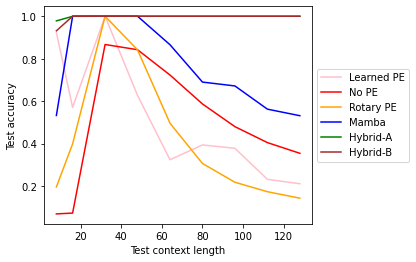

In [10]:
import matplotlib.pyplot as plt

with open(f'context_length_perf_tau1.jsonl', 'r') as readfile:
    model_perf = json.load(readfile) 

label_dict = {"pe": "Learned PE", "nope": "No PE", "rope": "Rotary PE", "mamba": "Mamba", "hybrid_a": "Hybrid-A", "hybrid_b": "Hybrid-B"}
color_dict = {"pe": "pink", "nope": "red", "rope": "orange", "mamba": "blue", "hybrid_a": "green", "hybrid_b": "brown"}
 
fig, ax = plt.subplots()
plt.xlabel("Test context length")
plt.ylabel("Test accuracy")
for model_name in models:
    ax.plot(n_ctx_list, model_perf[model_name], label = label_dict[model_name], color = color_dict[model_name])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("tau1_test_acc_ctx_lens.jpeg")
plt.show()


### Comments

1. **No PE:** Note that using no positional embeddings shows almost no length generalization and even has imperfect performance for the train context length (32)
2. **Learned PE:** Using learned absolute positional embeddings improves over this, since it is able to learned task and data-oriented positional embeddings and add them to the features. This however shows poor generalization since they are absolute positional embeddings.
3. **Rotary PE:** Even better are rotary positional embeddings, which are relative position embeddings and thus only rely on the query, key and the distance between them. Such embeddings can continue to function at unseen lengths since they are relative, and thus show better length generalization.
4. **Mamba:** Mamba performs better than any of the positional embeddings with a transformer, since state space models use dynamical systems to model sequences, and thus can inherently handle relative positions better. They are thus better at length generalization than transformers, which have to learn attention weights for fixed context lengths. However, Mamba is unable to perform perfectly at context lengths significantly far from the original.
5. **Hybrid-A:**  Mamba misses the "data-dependent averaging" ability of attention, which impedes the "selective focus" needed for memory and recall tasks, so adding an attention block allows it to improve upon this ability and Hybrid-A performs better than Mamba.
6. **Hybrid-B:** We get a similar performance with Hybrid-B, which merely adds another Mamba layer after Hybrid-A.

## Testing length generalization for tau=5, train context length = 32, batch size = 64, using residual connections

In [11]:
# Get dataset with tau=5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
seed = 0
n_ctx = 32 # training sequence length
num_examples = 100000 # generate 100000 examples
batch_size = 64 # batch size
vocab_size = 16 # vocabulary size
num_epochs = 250    # number of epochs
attn_layers = 2 # number of attention layers
embed_dim = 8 # embedding dimension
is_pe = True  # the default positional embedding we are using is the learned positional embedding
no_pe = False

tokenizer = Random_tokenizer(vocab_size=vocab_size)
# Setting tau = 5
dataset = InductionAR(num_examples, tokenizer, tau=5, n_gram=1, n_ctx=n_ctx, seed=seed, train_split=0.8)
train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

Using cuda device
Generating example 0
Generating example 1000
Generating example 2000
Generating example 3000
Generating example 4000
Generating example 5000
Generating example 6000
Generating example 7000
Generating example 8000
Generating example 9000
Generating example 10000
Generating example 11000
Generating example 12000
Generating example 13000
Generating example 14000
Generating example 15000
Generating example 16000
Generating example 17000
Generating example 18000
Generating example 19000
Generating example 20000
Generating example 21000
Generating example 22000
Generating example 23000
Generating example 24000
Generating example 25000
Generating example 26000
Generating example 27000
Generating example 28000
Generating example 29000
Generating example 30000
Generating example 31000
Generating example 32000
Generating example 33000
Generating example 34000
Generating example 35000
Generating example 36000
Generating example 37000
Generating example 38000
Generating example 3

This time we eval after every epoch to get a curve for eval loss against training steps for part 1.3

In [12]:
attn_model = BaseNet(len(tokenizer), embed_dim, is_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=Block, is_rope=False).to(device)
nope_model = BaseNet(len(tokenizer), embed_dim, no_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=Block, is_rope=False).to(device)
rope_model = BaseNet(len(tokenizer), embed_dim, no_pe,  max_len=n_ctx*4, attn_layers=attn_layers, block=Block, is_rope=True).to(device)

mamba_blocks = nn.ModuleList([MambaBlock(embed_dim), MambaBlock(embed_dim)])
hybrid_a_blocks = nn.ModuleList([MambaBlock(embed_dim), Block(embed_dim, max_len = 4*n_ctx)])
hybrid_b_blocks = nn.ModuleList([MambaBlock(embed_dim), Block(embed_dim, max_len = 4*n_ctx), MambaBlock(embed_dim)])

mamba = MambaNet(len(tokenizer), embed_dim, mamba_blocks).to(device)
hybrid_a = MambaNet(len(tokenizer), embed_dim, hybrid_a_blocks).to(device)
hybrid_b = MambaNet(len(tokenizer), embed_dim, hybrid_b_blocks).to(device)

already_done = ["pe", "nope", "rope", "mamba", "hybrid_a", "hybrid_b"]
tau5_models = {"pe": attn_model, "nope":nope_model, "rope":rope_model, "mamba": mamba, "hybrid_a":hybrid_a, "hybrid_b": hybrid_b} 

for model_name in already_done:
    tau5_models[model_name].load_state_dict(torch.load("tau5_models/" + model_name + ".pt"))

with open(f'train_loop_evals_tau_5.jsonl', 'r') as readfile:
    # Dictionary with list of eval losses during the training loop for each model
    eval_loss_vecs_tau_5 = json.load(readfile) 

# Training code
for model_name in tau5_models:
    if (model_name not in already_done):
        print(model_name)
        model = tau5_models[model_name]
        model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model(x)[:,-1]
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"epoch {epoch} loss: {total_loss/len(train_loader)}")

            # Eval every epoch
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    y_pred = model(x)[:,-1]
                    y_pred = F.softmax(y_pred, dim=-1)
                    y_pred = torch.argmax(y_pred, dim=-1)
                    correct += (y_pred == y).sum().item()
                    total += y.size(0)
                    
            # Add current epoch's eval loss to the dictionary
            eval_loss_vecs_tau_5[model_name].append(correct/total)
            print(f"Test accuracy: {correct/total}")
            
        # Save model
        torch.save(model.state_dict(), "tau5_models/" + f"{model_name}.pt")



BaseNet with 2 layers of <class '__main__.Block'> blocks
Embedding dimension: 8
Positional Encoding: True
Vocabulary size: 16
Context length: 128
BaseNet with 2 layers of <class '__main__.Block'> blocks
Embedding dimension: 8
Positional Encoding: False
Vocabulary size: 16
Context length: 128
BaseNet with 2 layers of <class '__main__.Block'> blocks
Embedding dimension: 8
Positional Encoding: False
Vocabulary size: 16
Context length: 128
MambaNet with 2 blocks: ModuleList(
  (0-1): 2 x MambaBlock(
    (in_proj): Linear(in_features=8, out_features=32, bias=False)
    (conv1d): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(3,), groups=16)
    (x_proj): Linear(in_features=16, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=16, bias=True)
    (out_proj): Linear(in_features=16, out_features=8, bias=False)
  )
)
Embedding dimension: 8
Positional Encoding: True
Vocabulary size: 16
MambaNet with 2 blocks: ModuleList(
  (0): MambaBlock(
    (in_proj): Linea

We save the dictionary of eval losses from training each model, made above

In [13]:
# Save dictionary of eval losses from training each model
import json 
with open(f'train_loop_evals_tau_5.jsonl', 'w') as outfile:
    json.dump(eval_loss_vecs_tau_5, outfile)
    outfile.write('\n')

We evaluate each model on various test context lengths

In [14]:
tau_5_model_perf = {model_name: [] for model_name in tau5_models}

# generate test data with length 16
# test the model with the test data
num_examples = 20000
n_ctx_list = [8, 16, 32, 48, 64, 80, 96, 112, 128]

for n_ctx in n_ctx_list:
    dataset = InductionAR(num_examples, tokenizer, tau=5, n_ctx=n_ctx, seed=seed, train_split=0.01)
    train_loader = DataLoader(dataset.train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset.test, batch_size=batch_size, shuffle=True)

    for model_name in tau5_models:
        model = tau5_models[model_name]
        model.load_state_dict(torch.load("tau5_models/" + model_name + ".pt"))
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x,y = x.to(device), y.to(device)
                y_pred = model(x)[:,-1]
                y_pred = F.softmax(y_pred, dim=-1)
                y_pred = torch.argmax(y_pred, dim=-1)
                correct += (y_pred == y).sum().item()
                total += y.size(0)
            tau_5_model_perf[model_name].append(correct/total)
            print(f"{model_name} test accuracy: {correct/total}")

Generating example 0
Generating example 1000
Generating example 2000
Generating example 3000
Generating example 4000
Generating example 5000
Generating example 6000
Generating example 7000
Generating example 8000
Generating example 9000
Generating example 10000
Generating example 11000
Generating example 12000
Generating example 13000
Generating example 14000
Generating example 15000
Generating example 16000
Generating example 17000
Generating example 18000
Generating example 19000
pe test accuracy: 0.7261111111111112
nope test accuracy: 0.1462121212121212
rope test accuracy: 0.9487373737373738
mamba test accuracy: 1.0
hybrid_a test accuracy: 0.9930808080808081
hybrid_b test accuracy: 0.9993434343434343
Generating example 0
Generating example 1000
Generating example 2000
Generating example 3000
Generating example 4000
Generating example 5000
Generating example 6000
Generating example 7000
Generating example 8000
Generating example 9000
Generating example 10000
Generating example 11000


In [15]:
with open(f'context_length_perf_tau5.jsonl', 'w') as outfile:
    json.dump(tau_5_model_perf, outfile)
    outfile.write('\n')
    
print(tau_5_model_perf)

{'pe': [0.7261111111111112, 0.9744949494949495, 0.9999494949494949, 0.5854040404040404, 0.07353535353535354, 0.37747474747474746, 0.3146464646464647, 0.22565656565656567, 0.2037878787878788], 'nope': [0.1462121212121212, 0.18398989898989898, 0.17914141414141413, 0.17863636363636365, 0.16777777777777778, 0.15419191919191919, 0.1442929292929293, 0.13540404040404042, 0.12383838383838384], 'rope': [0.9487373737373738, 0.9913131313131314, 1.0, 0.7907575757575758, 0.597020202020202, 0.3975757575757576, 0.32025252525252523, 0.2868686868686869, 0.22904040404040404], 'mamba': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'hybrid_a': [0.9930808080808081, 0.9994949494949495, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'hybrid_b': [0.9993434343434343, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999494949494949, 0.9992929292929293, 0.9960606060606061]}


Plot model accuracies against test context lengths in [8, 16, 32, 48, 64, 80, 96, 112, 128]

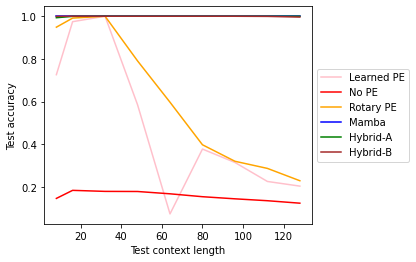

In [16]:
# Plotting performance against context length for each model
import matplotlib.pyplot as plt

with open(f'context_length_perf_tau5.jsonl', 'r') as readfile:
    tau_5_model_perf = json.load(readfile) 

label_dict = {"pe": "Learned PE", "nope": "No PE", "rope": "Rotary PE", "mamba": "Mamba", "hybrid_a": "Hybrid-A", "hybrid_b": "Hybrid-B"}
color_dict = {"pe": "pink", "nope": "red", "rope": "orange", "mamba": "blue", "hybrid_a": "green", "hybrid_b": "brown"}
 
fig, ax = plt.subplots()
plt.xlabel("Test context length")
plt.ylabel("Test accuracy")
for model_name in tau_5_model_perf:
    ax.plot(n_ctx_list, tau_5_model_perf[model_name], label = label_dict[model_name], color = color_dict[model_name])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("tau5_test_acc_ctx_lens.jpeg")
plt.show()


### Comments

Note that the logic from the conclusions in the first set of tests still holds, in terms of the general order between the models. However, note that the performance degradation of all 3 attention-only models is very stark, while the Mamba-based models continue to perform relatively well. In fact, this time, Mamba's performance is at the level of the Hybrid models. This means that the Mamba's performance for tau=1 possibly had some training-induced aberrations, but the overall reasoning is still supported.

In the context of the effect of delay, this shows that transformer models handle delay even more poorly at the level of length generalization, but state space models are able to generalize just as well even with a small amount of delay. This is because 

## Training curves for tau = 5, using residual connections, training context length = 32, training batch size = 64

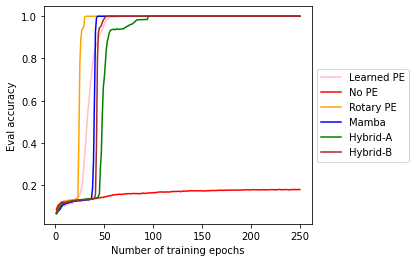

In [17]:
# Load dictionary with list of eval losses during the loop for each model, made during training
with open(f'train_loop_evals_tau_5.jsonl', 'r') as readfile:
    eval_loss_vecs_tau_5 = json.load(readfile) 

label_dict = {"pe": "Learned PE", "nope": "No PE", "rope": "Rotary PE", "mamba": "Mamba", "hybrid_a": "Hybrid-A", "hybrid_b": "Hybrid-B"}
color_dict = {"pe": "pink", "nope": "red", "rope": "orange", "mamba": "blue", "hybrid_a": "green", "hybrid_b": "brown"}
 
fig, ax = plt.subplots()
plt.xlabel("Number of training epochs")
plt.ylabel("Eval accuracy")
for model_name in eval_loss_vecs_tau_5:
    ax.plot(np.arange(1,251), eval_loss_vecs_tau_5[model_name], label = label_dict[model_name], color = color_dict[model_name])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("eval_loss_training_epochs.jpeg")
plt.show()

### Comments

We note that training curves typically have a sudden spike at a specific transition point (except for no PE, which is unable to learn the task well). This point comes very early for rotary PE, which makes sense since its relative positional embeddings are designed for transformer attention. Mamba and the hybrid models take slightly longer to reach this point, but the difference is not tremendous and could be due to hardware specific phenomena. The rise in the learned PE transformer is the least steep, which makes sense, since its embeddings or architecture is not already attuned to being compatible with relative positions.